# Bitcoin price prediction (Time series) using LSTM RNN

## ***I. Data Preparation***

### ***1. Load libraries***

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,SimpleRNN


### ***2.Read Data***

In [0]:
data = pd.read_csv("bitcoin_ticker.csv")
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


In [0]:
data.tail()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
627185,2017-07-14,2017-07-14 13:18:00,korbit,etc_krw,20900.0000,23310.0000,-10.338910,20840.0000,20910.00000,20000.0000,23400.00000,842321.282598,2017-07-14 04:17:20,2017-07-14 04:17:20
627186,2017-07-14,2017-07-14 13:18:00,bitflyer,eth_btc,0.0863,0.0941,-8.289054,0.0862,0.08675,0.0862,0.08675,4448.239195,2017-07-14 04:17:20,2017-07-14 04:17:20
627187,2017-07-14,2017-07-14 13:18:00,korbit,eth_krw,239100.0000,268950.0000,-11.098717,238600.0000,239100.00000,235000.0000,269000.00000,117124.419358,2017-07-14 04:17:20,2017-07-14 04:17:20
627188,2017-07-14,2017-07-14 13:18:00,bitflyer,fx_btc_jpy,261553.0000,271310.0000,-3.596255,261554.0000,261626.00000,261554.0000,261626.00000,73814.151389,2017-07-14 04:17:20,2017-07-14 04:17:20
627189,2017-07-14,2017-07-14 13:18:00,okcoin,ltc_usd,45.9310,48.9170,-6.104217,45.9540,46.20000,45.2410,49.07500,52799.710000,2017-07-14 04:17:20,2017-07-14 04:17:20


In [0]:
data.shape
# dữ liệu bao gồm 627190 mẫu và 14 thuộc tính

(627190, 14)

***Thuộc tính "rpt_key" mô tả tất cả các loại bitcoin (btc,etc,ltc,eth,fx_btc) với các giá trị tiền tệ khác nhau như : USD,KRW,JPY,EUR***

In [0]:
data['rpt_key'].value_counts()

btc_usd       125438
etc_krw        62719
btc_jpy        62719
ltc_usd        62719
btc_krw        62719
fx_btc_jpy     62719
eth_btc        62719
eth_krw        62719
btc_eur        62719
Name: rpt_key, dtype: int64

***Trong notebook này chúng ta chỉ sử dụng các bitcoin btc với loại tiền tệ là USD***

In [0]:
df = data.loc[(data['rpt_key'] == 'btc_usd')]
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


In [0]:
df.shape
# có 47676 mẫu được thu thập theo từng giờ

(125438, 14)

***Convert datetime_id to data type and filter dates greater than 2017-06-28 00:00:00***

In [0]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-28 00:00:00')]

In [0]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

In [0]:
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
0,2017-06-28 00:01:00,2344.00,2491.98,-5.938250,2335.01,2343.89,2307.0,2473.19,20719.583592
1,2017-06-28 00:01:00,2499.39,2682.25,-6.817411,2495.00,2499.33,2444.0,2780.62,2265.557866
2,2017-06-28 00:02:00,2337.18,2491.98,-6.211928,2337.18,2340.00,2307.0,2473.19,20732.082581
3,2017-06-28 00:02:00,2492.76,2682.25,-7.064591,2492.76,2495.00,2444.0,2780.62,2262.618866
4,2017-06-28 00:03:00,2335.02,2491.98,-6.298606,2335.01,2335.02,2307.0,2473.19,20665.357191


***Chỉ lấy một cột "last" để đưa vào model (bạn có thể chọn thuộc tính nào khác mà bạn thích)***

In [0]:
df = df[['last']]
df.head()

,last
0,2344.00
1,2499.39
2,2337.18
3,2492.76
4,2335.02


***Tạo tập dataset và chuyển về kiểu float***

In [0]:
dataset = df.values
dataset = dataset.astype('float32')

In [0]:
dataset

array([[2344.  ],
       [2499.39],
       [2337.18],
       ...,
       [2394.03],
       [2320.47],
       [2394.03]], dtype=float32)

***Vì mạng Neural rất nhạy cảm với dữ liệu đầu vào, đặc biệt khi chúng ta đang sử dụng các hàm kích hoạt như sigmoid hoặc  tanh .Vì thế chúng tôi đã chuyển dữ liệu cvề phạm vi từ 0 đến 1, bằng cách sử dụng hàm  MinMaxScaler!***

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [0]:
dataset

array([[0.1997695 ],
       [0.49828053],
       [0.18666792],
       ...,
       [0.29587936],
       [0.15456724],
       [0.29587936]], dtype=float32)

***Sau đó tôi thực hiện việc chia dataset ra thành tập huấn luyện (train dataset) và tập kiểm thử (test dataset)***

Một lưu ý là trong dữ liệu chuỗi thời gian bạn không được sử dụng thư viện để chia tập huấn luyện và tập kiểm thử vì như thế sẽ làm xáo trộn dữ liệu của chúng ta.

In [0]:
#scale : train 67%, test 33%
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

31942 15734


Sau khi chia tập kiểm thử và tập huần luyện thì tụi mình có 31942 mẫu cho tập huấn luyện và 15734 cho tập kiểm thử.

Bây giờ dữ liệu huấn luyện của mình sẽ như thế này.

In [0]:
print(train)

[[0.1997695 ]
 [0.49828053]
 [0.18666792]
 ...
 [0.7081547 ]
 [0.5206418 ]
 [0.70805883]]


Tụi mình cần chuyển đổi một mảng giá trị đó về một ma trận dataset



In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [0]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

Tập train bây của mình sẽ như thế này.

In [0]:
sampleX_1=train[0:10,0]
sampleY_1=train[10,0]

In [0]:
print(sampleX_1)
print(sampleY_1)

[0.1997695  0.49828053 0.18666792 0.4855442  0.18251848 0.48984718
 0.19590807 0.4975314  0.19973087 0.4860053 ]
0.18442059


In [0]:
trainX

array([[0.1997695 , 0.49828053, 0.18666792, ..., 0.4975314 , 0.19973087,
        0.4860053 ],
       [0.49828053, 0.18666792, 0.4855442 , ..., 0.19973087, 0.4860053 ,
        0.18442059],
       [0.18666792, 0.4855442 , 0.18251848, ..., 0.4860053 , 0.18442059,
        0.48598576],
       ...,
       [0.53376245, 0.6943617 , 0.53105354, ..., 0.7082124 , 0.5205841 ,
        0.7081547 ],
       [0.6943617 , 0.53105354, 0.70823145, ..., 0.5205841 , 0.7081547 ,
        0.52665424],
       [0.53105354, 0.70823145, 0.5332055 , ..., 0.7081547 , 0.52665424,
        0.7081547 ]], dtype=float32)

In [0]:
trainY

array([0.18442059, 0.48598576, 0.19208527, ..., 0.52665424, 0.7081547 ,
       0.5206418 ], dtype=float32)

 Cuối cùng tụi mình reshape  dữ liệu lại trước khi đưa vào mô mình

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## ***II. XÂY DỰNG MÔ HÌNH***

### ***1. LONG SHORT TERM MEMORY (LSTM)***

In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, look_back)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 1s - loss: 0.0303
Epoch 2/100
 - 0s - loss: 0.0073
Epoch 3/100
 - 0s - loss: 0.0045
Epoch 4/100
 - 0s - loss: 0.0021
Epoch 5/100
 - 0s - loss: 6.8284e-04
Epoch 6/100
 - 0s - loss: 2.2635e-04
Epoch 7/100
 - 0s - loss: 1.3851e-04
Epoch 8/100
 - 0s - loss: 1.2568e-04
Epoch 9/100
 - 0s - loss: 1.2311e-04
Epoch 10/100
 - 0s - loss: 1.2221e-04
Epoch 11/100
 - 0s - loss: 1.2159e-04
Epoch 12/100
 - 0s - loss: 1.2079e-04
Epoch 13/100
 - 0s - loss: 1.2000e-04
Epoch 14/100
 - 0s - loss: 1.1944e-04
Epoch 15/100
 - 0s - loss: 1.1874e-04
Epoch 16/100
 - 0s - loss: 1.1811e-04
Epoch 17/100
 - 0s - loss: 1.1750e-04
Epoch 18/100
 - 0s - loss: 1.1676e-04
Epoch 19/100
 - 0s - loss: 1.1621e-04
Epoch 20/100
 - 0s - loss: 1.1570e-04
Epoch 21/100
 - 0s - loss: 1.1497e-04
Epoch 22/100
 - 0s - loss: 1.1441e-04
Epoch 23/100
 - 0s - loss: 1.1406e-04
Epoch 24/100
 - 0s - loss: 1.13

In [0]:
lstm_predictions = lstm_model.predict(testX)

lstm_score = r2_score(testY,lstm_predictions)

### ***2. RECURRENT NEURAL NETWORK (RNN)***

In [0]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(4, input_shape=(1, look_back)))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')
rnn_model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
 - 0s - loss: 0.7408
Epoch 2/100
 - 0s - loss: 0.0146
Epoch 3/100
 - 0s - loss: 0.0075
Epoch 4/100
 - 0s - loss: 0.0063
Epoch 5/100
 - 0s - loss: 0.0051
Epoch 6/100
 - 0s - loss: 0.0042
Epoch 7/100
 - 0s - loss: 0.0034
Epoch 8/100
 - 0s - loss: 0.0028
Epoch 9/100
 - 0s - loss: 0.0024
Epoch 10/100
 - 0s - loss: 0.0021
Epoch 11/100
 - 0s - loss: 0.0018
Epoch 12/100
 - 0s - loss: 0.0016
Epoch 13/100
 - 0s - loss: 0.0015
Epoch 14/100
 - 0s - loss: 0.0014
Epoch 15/100
 - 0s - loss: 0.0012
Epoch 16/100
 - 0s - loss: 0.0011
Epoch 17/100
 - 0s - loss: 0.0010
Epoch 18/100
 - 0s - loss: 9.2085e-04
Epoch 19/100
 - 0s - loss: 8.2594e-04
Epoch 20/100
 - 0s - loss: 7.3788e-04
Epoch 21/100
 - 0s - loss: 6.5672e-04
Epoch 22/100
 - 0s - loss: 5.8259e-04
Epoch 23/100
 - 0s - loss: 5.1606e-04
Epoch 24/100
 - 0s - loss: 4.5688e-04
Epoch 25/100
 - 0s - loss: 4.0486e-04
Epoch 26/100
 - 0s - loss: 3.5992e-04
Epoch 27/100
 - 0s - loss: 3.2191e-04
Epoch 28/100
 - 0s - loss: 2.9003e-04
Epoch 29/100


In [0]:
rnn_predictions = rnn_model.predict(testX)

rnn_score = r2_score(testY,rnn_predictions)

### ***3. EVALUATE***

In [0]:
print("R^2 Score of RNN",rnn_score)
print("R^2 Score of LSTM",lstm_score)

R^2 Score of RNN 0.9955172794248569
R^2 Score of LSTM 0.9970190605301679


In [0]:
lstm_predictions = scaler.inverse_transform(lstm_predictions)
rnn_predictions = scaler.inverse_transform(rnn_predictions)
testY = scaler.inverse_transform(testY.reshape(-1,1))

In [0]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Bitcoin Price')
    plt.plot(predicted, color='blue',label='Predicted Bitcoin Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Bitcoin Stock Price')
    plt.legend()
    plt.show()

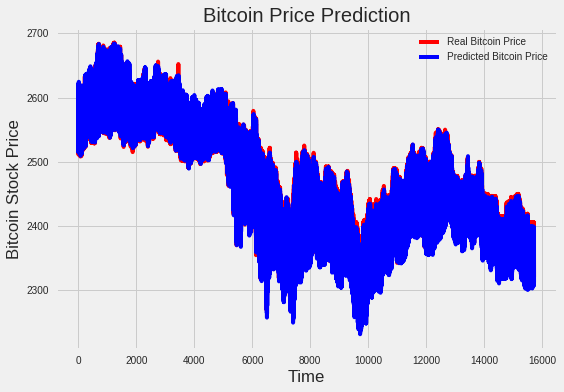

In [0]:
plot_predictions(testY,rnn_predictions)

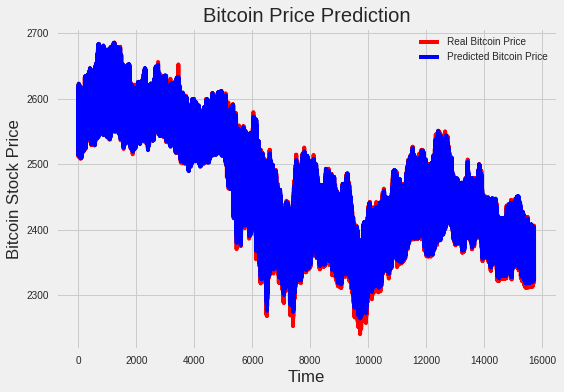

In [0]:
plot_predictions(testY,lstm_predictions)

In [0]:
def plot_predictions(test,predicted1,predicted2):
    plt.plot(test, color='red',linewidth=7,label='Real Bitcoin Price')
    plt.plot(lstm_predictions, c="green",linewidth=6, label="LSTM")
    plt.plot(rnn_predictions, c="blue",linewidth=0.1, label="RNN")
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Bitcoin Stock Price')
    plt.legend()
    plt.show()

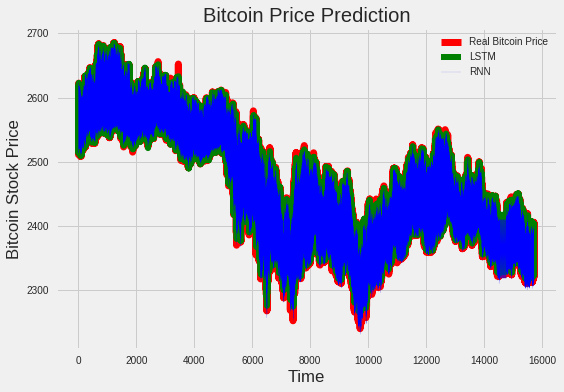

In [0]:
plot_predictions(testY,lstm_predictions,rnn_predictions)